## ANN Portfolio

### Task 1 - Sudoku Image Reading

##### Approach 1 - Sudoku digit recognizer with MNIST dataset

In [1]:
import torch
import torch.nn as nn
from torchvision import datasets
from torch.utils.data import DataLoader
from torch import optim
from torchvision import transforms
from torch.utils.data import random_split
import matplotlib.pyplot as plt 
import numpy as np

In [2]:
def _get_conv_output_size(input_size, out_channels, model):
    batch_size = 1
    input_tensor = torch.autograd.Variable(torch.rand(batch_size, *input_size))
    output_feat = model.features(input_tensor)
    n_size = output_feat.data.view(batch_size, -1).size(1)
    return n_size

In [3]:
class MNIST(nn.Module):
    def __init__(self, out_channels):
        super(MNIST, self).__init__()

        conv_layers = []
        num_conv_layers = len(out_channels)

        for i in range(num_conv_layers):
            if i == 0:
                conv_layers.append(nn.Conv2d(1, out_channels[i], kernel_size=3, padding=1))
            else:
                conv_layers.append(nn.Conv2d(out_channels[i-1], out_channels[i], kernel_size=3, padding=1))

            conv_layers.append(nn.ReLU())
            conv_layers.append(nn.MaxPool2d(kernel_size=2, stride=2))

        self.features = nn.Sequential(*conv_layers)
        self.fc1 = nn.Linear(_get_conv_output_size((1, 28, 28), out_channels, self), 256)
        self.fc2 = nn.Linear(256, 10)

    def forward(self, x):
        x = self.features(x)
        x = x.view(x.size(0), -1)
        x = self.fc1(x)
        x = self.fc2(x)
        return x


In [4]:
def mnist_train(out_channels, num_epochs, batch_size, learning_rate, device, plots):
    transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.5,), (0.5,))])

    train_dataset = datasets.MNIST(root='./mnist/train', train=True, download=False, transform=transform)
    test_dataset = datasets.MNIST(root='./mnist/test', train=False, download=False, transform=transform)
    
    # Coz filled sudokus - some digits are incorrectly getting classified as 0
    indices_to_keep = [i for i, (image, label) in enumerate(train_dataset)]
    #indices_to_keep = [i for i, (image, label) in enumerate(train_dataset) if label != 0]
    filtered_train_dataset = torch.utils.data.Subset(train_dataset, indices_to_keep)

    train_loader = torch.utils.data.DataLoader(filtered_train_dataset, batch_size=batch_size, shuffle=True)
    test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

    mnist_model = MNIST(out_channels)
    mnist_model.to(device)


    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(mnist_model.parameters(), lr=learning_rate)

    train_losses = []
    test_losses = []
    accuracies = []

    # Training loop
    for epoch in range(num_epochs):
        # Train the model
        mnist_model.train()
        train_loss = 0.0
        correct = 0
        total = 0
        for images, labels in train_loader:
            images = images.to(device)
            labels = labels.to(device)

            optimizer.zero_grad()
            outputs = mnist_model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            train_loss += loss.item() * images.size(0)

            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

        train_loss /= len(train_loader.dataset)
        train_losses.append(train_loss)

        accuracy = 100 * (correct / total)
        accuracies.append(accuracy)

        mnist_model.eval()
        test_loss = 0.0
        correct = 0
        total = 0
        with torch.no_grad():
            for images, labels in test_loader:
                images = images.to(device)
                labels = labels.to(device)

                outputs = mnist_model(images)
                loss = criterion(outputs, labels)
                test_loss += loss.item() * images.size(0)

                _, predicted = torch.max(outputs.data, 1)
                total += labels.size(0)
                correct += (predicted == labels).sum().item()

        test_loss /= len(test_loader.dataset)
        test_losses.append(test_loss)

        print(f"Epoch [{epoch + 1}/{num_epochs}], Train Loss: {train_loss:.4f}, Validation Loss: {test_loss:.4f}, Accuracy: {accuracy:.2f}")

    if plots:
        plt.plot(range(1, num_epochs + 1), train_losses, label='Train Loss')
        plt.plot(range(1, num_epochs + 1), test_losses, label='Validation Loss')
        plt.xlabel('Epoch')
        plt.ylabel('Loss')
        plt.legend()
        plt.show()

        plt.plot(range(1, num_epochs + 1), accuracies, label='Accuracy')
        plt.xlabel('Epoch')
        plt.ylabel('Accuracy')
        plt.legend()
        plt.show()

    return mnist_model, (train_losses, test_losses, accuracies)

Epoch [1/10], Train Loss: 0.1236, Validation Loss: 0.0679, Accuracy: 96.14
Epoch [2/10], Train Loss: 0.0442, Validation Loss: 0.0307, Accuracy: 98.67
Epoch [3/10], Train Loss: 0.0322, Validation Loss: 0.0409, Accuracy: 98.96
Epoch [4/10], Train Loss: 0.0277, Validation Loss: 0.0352, Accuracy: 99.12
Epoch [5/10], Train Loss: 0.0220, Validation Loss: 0.0338, Accuracy: 99.31
Epoch [6/10], Train Loss: 0.0188, Validation Loss: 0.0348, Accuracy: 99.43
Epoch [7/10], Train Loss: 0.0170, Validation Loss: 0.0536, Accuracy: 99.47
Epoch [8/10], Train Loss: 0.0170, Validation Loss: 0.0438, Accuracy: 99.47
Epoch [9/10], Train Loss: 0.0135, Validation Loss: 0.0322, Accuracy: 99.61
Epoch [10/10], Train Loss: 0.0140, Validation Loss: 0.0369, Accuracy: 99.58


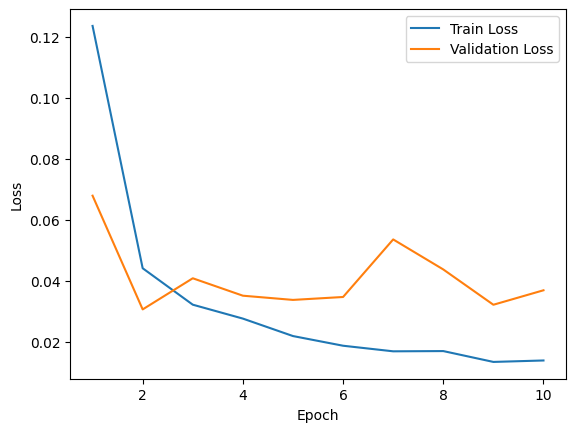

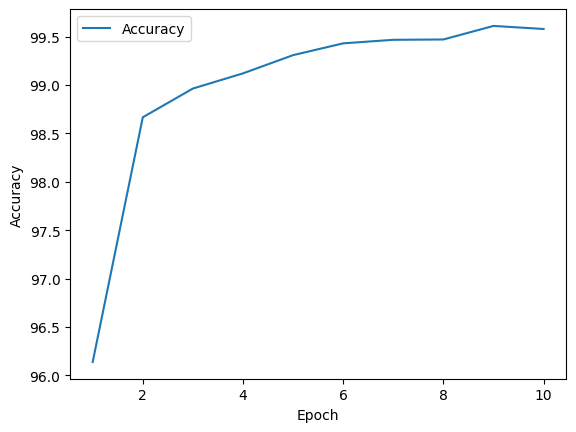

MNIST(
  (features): Sequential(
    (0): Conv2d(1, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): ReLU()
    (5): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(32, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU()
    (8): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (fc1): Linear(in_features=1152, out_features=256, bias=True)
  (fc2): Linear(in_features=256, out_features=10, bias=True)
)


In [5]:
import torch

out_channels = [16, 32, 128] 
num_epochs = 10
batch_size = 34
learning_rate = 0.001
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
plots = True 

mnist_model, (train_losses, test_losses, accuracies) = mnist_train(out_channels, num_epochs, batch_size, learning_rate, device, plots)
print(mnist_model)

In [6]:
import torch
import numpy as np
from torch.utils.data import TensorDataset

test_images = np.load('./Task1/test/imgs.npy')

test_images_tensor = torch.Tensor(test_images)
test_dataset = TensorDataset(test_images_tensor)  
test_images.shape

(10000, 252, 252)

In [7]:
from torchvision import transforms

transform = transforms.Compose([   
    transforms.Normalize((0.5,), (0.5,)), 
    transforms.ToTensor(),  
])
test_dataset.transform = transform

In [8]:
import torch
import matplotlib.pyplot as plt

def mnist_apply(model, images):

    if torch.cuda.is_available():
        device = 'cuda'
    else:
        device = 'cpu'

    images = images.to(device)
    
    if torch.sum(images) == 0:
        return 0  

    images = images.unsqueeze(0)
    images = torch.nn.functional.interpolate(images.unsqueeze(0), size=(28, 28), mode='nearest').squeeze(0)
        
    with torch.no_grad():
        output = model(images.unsqueeze(0))
        _, predicted = torch.max(output, 1)
    
    return predicted.item()


In [9]:
sudoku_grid_size=81
x=y=9

In [10]:
sudoku_tensor = torch.zeros(10000, 9, 9)

print(sudoku_tensor.shape)

partial_sudokus=np.empty(10000, dtype=object)

torch.Size([10000, 9, 9])


In [11]:
image=0
for sudoku_tuple in test_dataset:
    sudoku_grid = sudoku_tuple[0]  
    cell=0
    partial_sudokus[image] = []
    for cell in range(sudoku_grid_size):
        cell_digit = sudoku_grid[
                            (cell // 9) * 28: (cell // 9 + 1) * 28,
                            (cell % 9) * 28: (cell % 9 + 1) * 28
                        ]
        digit_value = mnist_apply(mnist_model, cell_digit)
        x, y = divmod(cell, 9)
        sudoku_tensor[image, x, y] = digit_value
        partial_sudokus[image].append(digit_value)
        
        cell+=1
    image+=1

In [12]:
partial_sudokus

array([list([2, 0, 7, 0, 1, 3, 4, 0, 0, 8, 0, 6, 0, 4, 8, 2, 3, 5, 9, 0, 3, 0, 0, 6, 8, 0, 0, 0, 9, 0, 0, 5, 0, 0, 2, 0, 1, 0, 8, 9, 7, 0, 5, 8, 0, 0, 3, 0, 0, 0, 2, 0, 0, 8, 3, 6, 1, 4, 0, 0, 7, 8, 0, 0, 8, 0, 0, 0, 8, 0, 1, 0, 4, 0, 2, 0, 8, 0, 3, 0, 0]),
       list([0, 0, 2, 0, 8, 0, 0, 4, 9, 0, 0, 4, 1, 0, 0, 7, 0, 8, 8, 0, 5, 4, 0, 6, 0, 0, 3, 2, 6, 0, 7, 0, 0, 0, 0, 0, 7, 0, 5, 2, 0, 0, 0, 8, 6, 3, 1, 0, 8, 6, 5, 0, 7, 0, 9, 7, 0, 3, 0, 8, 2, 0, 0, 5, 2, 0, 6, 2, 4, 0, 0, 0, 0, 8, 6, 0, 7, 0, 5, 0, 0]),
       list([0, 0, 0, 0, 4, 6, 3, 0, 0, 8, 0, 0, 9, 8, 3, 7, 5, 6, 0, 5, 3, 0, 2, 8, 0, 0, 9, 0, 0, 4, 0, 0, 9, 0, 0, 2, 0, 8, 0, 6, 0, 0, 0, 4, 0, 0, 0, 2, 9, 8, 0, 0, 9, 1, 8, 0, 2, 0, 5, 7, 9, 6, 0, 0, 0, 6, 0, 9, 0, 1, 8, 5, 0, 9, 5, 0, 6, 0, 0, 7, 0]),
       ...,
       list([2, 8, 7, 5, 0, 0, 0, 0, 3, 0, 0, 0, 0, 8, 7, 0, 0, 4, 5, 3, 4, 0, 9, 6, 2, 0, 7, 0, 0, 6, 0, 3, 1, 0, 0, 0, 9, 0, 3, 0, 4, 0, 2, 0, 0, 0, 4, 1, 0, 6, 0, 0, 0, 0, 2, 0, 0, 4, 7, 3, 9, 6, 8, 0, 0, 8, 6, 

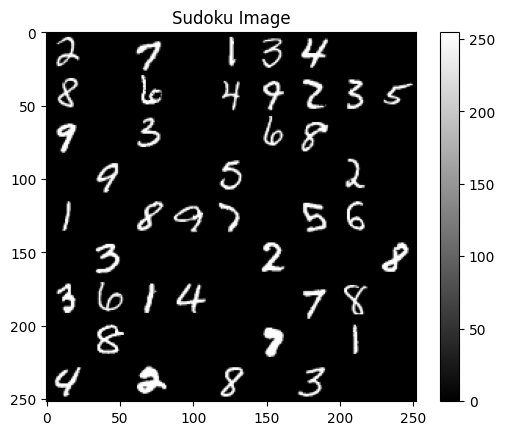

In [13]:
import matplotlib.pyplot as plt

image = test_images[0, :, :]

plt.imshow(image, cmap='gray')  # 'gray' colormap for grayscale images
plt.title('Sudoku Image')
plt.colorbar()  # Add a colorbar to show pixel values
plt.show()


In [14]:
sudoku = sudoku_tensor.numpy()
sudoku.shape

(10000, 9, 9)

In [15]:
import pandas as pd
df = pd.DataFrame(columns=['id', 'value'])
df = df.reset_index(drop=True)

In [16]:
rows = []

for image in range(sudoku.shape[0]):
    for x in range(sudoku.shape[1]):
        for y in range(sudoku.shape[2]):
            cell_id = f'{image}_{x}{y}'
            cell_value = sudoku[image][x][y]
            rows.append({'id': cell_id, 'value': cell_value})


In [17]:
df = pd.DataFrame(rows)
df['value'] = df['value'].astype(int)
df

,id,value
0,0_00,2
1,0_01,0
2,0_02,7
3,0_03,0
4,0_04,1
...,...,...
809995,9999_84,3
809996,9999_85,5
809997,9999_86,2
809998,9999_87,0


In [18]:
df.to_csv('Submission_Task1_CNN.csv', index=False)

### Summary
* Loaded the mnist handwritten digits as is mentioned in [Paper](https://arxiv.org/pdf/2106.03121v1.pdf)  to predict each cell of the sudoku grid
* Excluded 0 labels as this incorrectly classifies unintelligible digits
* Trained CNN model to make predictions on each cell of test images checking if no pixels in test images, then hardcode the label as 0 
* Loaded a 3d tensor object so that image id, x and postions and its values are stored in each entry to easily extract as is in the submissin file format

For Task 2

In [19]:
import pandas as pd

data = np.array([np.array(partial_sudoku) for partial_sudoku in partial_sudokus])
df = pd.DataFrame(data)

In [20]:
df

,0,1,2,3,4,5,6,7,8,9,...,71,72,73,74,75,76,77,78,79,80
0,2,0,7,0,1,3,4,0,0,8,...,0,4,0,2,0,8,0,3,0,0
1,0,0,2,0,8,0,0,4,9,0,...,0,0,8,6,0,7,0,5,0,0
2,0,0,0,0,4,6,3,0,0,8,...,5,0,9,5,0,6,0,0,7,0
3,0,0,4,5,0,0,0,0,6,2,...,7,0,7,3,4,0,0,2,0,0
4,0,0,9,0,0,3,0,0,0,0,...,8,2,0,0,8,4,7,9,3,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9995,3,0,1,0,0,2,9,8,0,0,...,9,0,1,2,0,0,8,5,0,0
9996,0,0,0,0,7,2,6,0,9,0,...,0,5,0,0,0,2,0,0,0,0
9997,2,8,7,5,0,0,0,0,3,0,...,0,3,6,9,0,0,0,0,4,2
9998,7,0,0,4,1,0,0,9,8,0,...,0,0,7,2,0,0,3,4,0,0


In [21]:
# Save the DataFrame to a CSV file
#df.to_csv('test_sudokus.csv', index=False, header=True)

##### Approach 2 - Sudoku digit recognizer with given dataset

In [22]:
import numpy as np

In [23]:
train_images = np.load('./Task1/train/imgs-001.npy')
test_images = np.load('./Task1/test/imgs.npy')

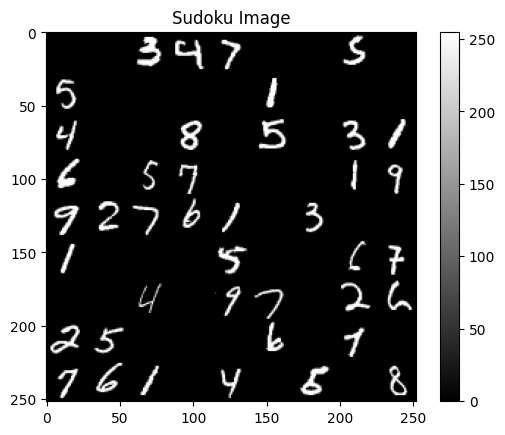

In [24]:
import matplotlib.pyplot as plt

image = train_images[0, :, :]

plt.imshow(image, cmap='gray')  
plt.title('Sudoku Image')
plt.colorbar() 
plt.show()


In [25]:
import torch
from torchvision import transforms

new_size = (128, 128)

transform = transforms.Compose([
    transforms.Resize(new_size),
    transforms.ToTensor(),  
])

resized_train_images = torch.stack([transform(image) for image in train_images])
resized_test_images = torch.stack([transform(image) for image in test_images])

normalized_resized_train_images = resized_train_images / 255.0
normalized_resized_test_images = resized_test_images / 255.0

print(normalized_resized_train_images.shape)
print(normalized_resized_test_images.shape)

torch.Size([50000, 1, 128, 128])
torch.Size([10000, 1, 128, 128])


In [26]:
normalized_resized_train_images = resized_train_images.squeeze(dim=1)
print(normalized_resized_train_images.shape)

normalized_resized_test_images = resized_test_images.squeeze(dim=1)
print(normalized_resized_test_images.shape)

torch.Size([50000, 128, 128])
torch.Size([10000, 128, 128])


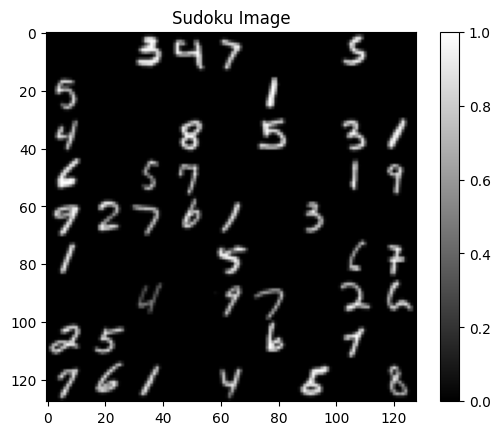

In [27]:
import matplotlib.pyplot as plt

image = normalized_resized_train_images[0, :, :]

plt.imshow(image, cmap='gray')  
plt.title('Sudoku Image')
plt.colorbar()  
plt.show()


In [28]:
def preprocess_images(images, new_size=(14, 14)):
    num_images = images.shape[0]
    processed_images = np.zeros((num_images * 81, new_size[0], new_size[1]))

    for idx in range(num_images):
        for row in range(9):
            for col in range(9):
                cell = images[idx, row*new_size[0]:(row+1)*new_size[0], col*new_size[1]:(col+1)*new_size[1]]
                processed_images[idx * 81 + row * 9 + col]  = cell

    return processed_images

normalized_resized_train_images_np = normalized_resized_train_images.cpu().numpy()

train_images_processed = preprocess_images(normalized_resized_train_images_np)
train_images_processed.shape

(4050000, 14, 14)

In [29]:
test_images_processed = preprocess_images(normalized_resized_test_images.cpu().numpy())
test_images_processed.shape

(810000, 14, 14)

In [30]:
train_labels = np.load('./Task1/train/known_values_labels.npy')

train_labels #x, y, value
train_labels.shape

(50000, 41, 3)

In [31]:
import numpy as np

empty_train_labels = np.zeros((1, 81, 3))

x_values, y_values = np.indices((9, 9))
empty_train_labels[:, :, 0] = x_values.flatten()
empty_train_labels[:, :, 1] = y_values.flatten()

print(empty_train_labels)

[[[0. 0. 0.]
  [0. 1. 0.]
  [0. 2. 0.]
  [0. 3. 0.]
  [0. 4. 0.]
  [0. 5. 0.]
  [0. 6. 0.]
  [0. 7. 0.]
  [0. 8. 0.]
  [1. 0. 0.]
  [1. 1. 0.]
  [1. 2. 0.]
  [1. 3. 0.]
  [1. 4. 0.]
  [1. 5. 0.]
  [1. 6. 0.]
  [1. 7. 0.]
  [1. 8. 0.]
  [2. 0. 0.]
  [2. 1. 0.]
  [2. 2. 0.]
  [2. 3. 0.]
  [2. 4. 0.]
  [2. 5. 0.]
  [2. 6. 0.]
  [2. 7. 0.]
  [2. 8. 0.]
  [3. 0. 0.]
  [3. 1. 0.]
  [3. 2. 0.]
  [3. 3. 0.]
  [3. 4. 0.]
  [3. 5. 0.]
  [3. 6. 0.]
  [3. 7. 0.]
  [3. 8. 0.]
  [4. 0. 0.]
  [4. 1. 0.]
  [4. 2. 0.]
  [4. 3. 0.]
  [4. 4. 0.]
  [4. 5. 0.]
  [4. 6. 0.]
  [4. 7. 0.]
  [4. 8. 0.]
  [5. 0. 0.]
  [5. 1. 0.]
  [5. 2. 0.]
  [5. 3. 0.]
  [5. 4. 0.]
  [5. 5. 0.]
  [5. 6. 0.]
  [5. 7. 0.]
  [5. 8. 0.]
  [6. 0. 0.]
  [6. 1. 0.]
  [6. 2. 0.]
  [6. 3. 0.]
  [6. 4. 0.]
  [6. 5. 0.]
  [6. 6. 0.]
  [6. 7. 0.]
  [6. 8. 0.]
  [7. 0. 0.]
  [7. 1. 0.]
  [7. 2. 0.]
  [7. 3. 0.]
  [7. 4. 0.]
  [7. 5. 0.]
  [7. 6. 0.]
  [7. 7. 0.]
  [7. 8. 0.]
  [8. 0. 0.]
  [8. 1. 0.]
  [8. 2. 0.]
  [8. 3. 0.]
  [8. 4. 0.]

In [32]:
appended_labels = np.zeros((train_labels.shape[0], 81, 3))

for i in range(train_labels.shape[0]):
    puzzle_labels = train_labels[i]

    puzzle_indices = puzzle_labels[:, :2].astype(int)
    all_indices = np.arange(81)
    missing_indices = np.setdiff1d(all_indices, np.ravel_multi_index(puzzle_indices.T, (9, 9)), assume_unique=True)

    missing_indices = missing_indices[missing_indices < 81]

    appended_labels[i, :puzzle_labels.shape[0], :] = puzzle_labels

    appended_labels[i, puzzle_labels.shape[0]:puzzle_labels.shape[0]+len(missing_indices), :] = empty_train_labels[0, missing_indices, :]

    sorted_indices = np.lexsort((appended_labels[i, :, 1], appended_labels[i, :, 0]))
    appended_labels[i] = appended_labels[i, sorted_indices]

print(appended_labels[0])

[[0. 0. 0.]
 [0. 1. 0.]
 [0. 2. 3.]
 [0. 3. 4.]
 [0. 4. 7.]
 [0. 5. 0.]
 [0. 6. 0.]
 [0. 7. 5.]
 [0. 8. 0.]
 [1. 0. 5.]
 [1. 1. 0.]
 [1. 2. 0.]
 [1. 3. 0.]
 [1. 4. 0.]
 [1. 5. 1.]
 [1. 6. 0.]
 [1. 7. 0.]
 [1. 8. 0.]
 [2. 0. 4.]
 [2. 1. 0.]
 [2. 2. 0.]
 [2. 3. 8.]
 [2. 4. 0.]
 [2. 5. 5.]
 [2. 6. 0.]
 [2. 7. 3.]
 [2. 8. 1.]
 [3. 0. 6.]
 [3. 1. 0.]
 [3. 2. 5.]
 [3. 3. 7.]
 [3. 4. 0.]
 [3. 5. 0.]
 [3. 6. 0.]
 [3. 7. 1.]
 [3. 8. 9.]
 [4. 0. 9.]
 [4. 1. 2.]
 [4. 2. 7.]
 [4. 3. 6.]
 [4. 4. 1.]
 [4. 5. 0.]
 [4. 6. 3.]
 [4. 7. 0.]
 [4. 8. 0.]
 [5. 0. 1.]
 [5. 1. 0.]
 [5. 2. 0.]
 [5. 3. 0.]
 [5. 4. 5.]
 [5. 5. 0.]
 [5. 6. 0.]
 [5. 7. 6.]
 [5. 8. 7.]
 [6. 0. 0.]
 [6. 1. 0.]
 [6. 2. 4.]
 [6. 3. 0.]
 [6. 4. 9.]
 [6. 5. 7.]
 [6. 6. 0.]
 [6. 7. 2.]
 [6. 8. 6.]
 [7. 0. 2.]
 [7. 1. 5.]
 [7. 2. 0.]
 [7. 3. 0.]
 [7. 4. 0.]
 [7. 5. 6.]
 [7. 6. 0.]
 [7. 7. 7.]
 [7. 8. 0.]
 [8. 0. 7.]
 [8. 1. 6.]
 [8. 2. 1.]
 [8. 3. 0.]
 [8. 4. 4.]
 [8. 5. 0.]
 [8. 6. 5.]
 [8. 7. 0.]
 [8. 8. 8.]]


In [33]:
modified_labels = np.array(appended_labels)
modified_labels

array([[[0., 0., 0.],
        [0., 1., 0.],
        [0., 2., 3.],
        ...,
        [8., 6., 5.],
        [8., 7., 0.],
        [8., 8., 8.]],

       [[0., 0., 7.],
        [0., 1., 2.],
        [0., 2., 0.],
        ...,
        [8., 6., 0.],
        [8., 7., 0.],
        [8., 8., 0.]],

       [[0., 0., 7.],
        [0., 1., 0.],
        [0., 2., 0.],
        ...,
        [8., 6., 0.],
        [8., 7., 0.],
        [8., 8., 8.]],

       ...,

       [[0., 0., 0.],
        [0., 1., 2.],
        [0., 2., 0.],
        ...,
        [8., 6., 7.],
        [8., 7., 0.],
        [8., 8., 0.]],

       [[0., 0., 5.],
        [0., 1., 0.],
        [0., 2., 2.],
        ...,
        [8., 6., 5.],
        [8., 7., 0.],
        [8., 8., 7.]],

       [[0., 0., 0.],
        [0., 1., 0.],
        [0., 2., 4.],
        ...,
        [8., 6., 5.],
        [8., 7., 0.],
        [8., 8., 0.]]])

In [34]:
train_labels_tensor = torch.tensor(modified_labels)
print(train_labels_tensor.shape)

torch.Size([50000, 81, 3])


In [35]:
def prepare_labels(labels):

    num_images = len(labels)
    new_labels = np.zeros((num_images * 81), dtype=int)

    for i, label in enumerate(labels):
        for cell in label:
            x, y, value = cell
            x, y, value = int(x), int(y), int(value)  
            if 0 <= x < 9 and 0 <= y < 9:  
                # Convert 2D coordinates to 1D index and set the value
                new_labels[i * 81 + x * 9 + y] = value

    return new_labels

train_labels_processed = prepare_labels(train_labels)

train_labels_processed.shape
train_images_processed.shape

(4050000, 14, 14)

In [36]:
train_labels_processed = torch.tensor(train_labels_processed, dtype=torch.long)
train_images_processed = torch.tensor(train_images_processed, dtype=torch.float32)
test_images_processed = torch.tensor(test_images_processed, dtype=torch.float32)

In [37]:
train_images_processed=train_images_processed.unsqueeze(1)
test_images_processed=test_images_processed.unsqueeze(1)

In [38]:
print(train_labels_processed.shape)
print(train_images_processed.shape)
print(test_images_processed.shape)

torch.Size([4050000])
torch.Size([4050000, 1, 14, 14])
torch.Size([810000, 1, 14, 14])


In [39]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import TensorDataset, DataLoader

images = train_images_processed
labels = train_labels_processed

dataset = TensorDataset(images, labels)

#Split into train and validation datasets

total_size=len(dataset)
train_size = 40000*81  # 10000 images for validation and 40000 images for testing
val_size = total_size - train_size

In [40]:
train_dataset = TensorDataset(*dataset[:train_size])
val_dataset = TensorDataset(*dataset[train_size:])
print(len(train_dataset))
print(len(val_dataset))

3240000
810000


In [41]:
batch_size = 64  
train_data_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=False)
eval_data_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

In [42]:
class MLPModel(nn.Module):
    def __init__(self):
        super(MLPModel, self).__init__()
        self.flatten = nn.Flatten()
        self.fc1 = nn.Linear(14 * 14, 128)
        self.relu = nn.ReLU()
        self.fc2 = nn.Linear(128, 10)  # 10 classes from 0 to 9

    def forward(self, x):
        x = self.flatten(x)
        x = self.fc1(x)
        x = self.relu(x)
        x = self.fc2(x)
        return x

model = MLPModel()
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

num_epochs = 10  
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

MLPModel(
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (fc1): Linear(in_features=196, out_features=128, bias=True)
  (relu): ReLU()
  (fc2): Linear(in_features=128, out_features=10, bias=True)
)

In [43]:
def calculate_accuracy(outputs, labels):
    _, predicted = torch.max(outputs, dim=1)
    correct = (predicted == labels).sum().item()
    return correct / labels.size(0)

Epoch 1: Train Loss: 0.0635, Train Accuracy: 0.9815, Validation Loss: 0.0305, Validation Accuracy: 0.9904
Epoch 2: Train Loss: 0.0271, Train Accuracy: 0.9915, Validation Loss: 0.0234, Validation Accuracy: 0.9927
Epoch 3: Train Loss: 0.0219, Train Accuracy: 0.9931, Validation Loss: 0.0205, Validation Accuracy: 0.9934
Epoch 4: Train Loss: 0.0191, Train Accuracy: 0.9939, Validation Loss: 0.0187, Validation Accuracy: 0.9941
Epoch 5: Train Loss: 0.0172, Train Accuracy: 0.9945, Validation Loss: 0.0174, Validation Accuracy: 0.9945
Epoch 6: Train Loss: 0.0160, Train Accuracy: 0.9949, Validation Loss: 0.0170, Validation Accuracy: 0.9946
Epoch 7: Train Loss: 0.0151, Train Accuracy: 0.9952, Validation Loss: 0.0172, Validation Accuracy: 0.9946
Epoch 8: Train Loss: 0.0144, Train Accuracy: 0.9954, Validation Loss: 0.0175, Validation Accuracy: 0.9945
Epoch 9: Train Loss: 0.0138, Train Accuracy: 0.9956, Validation Loss: 0.0170, Validation Accuracy: 0.9946


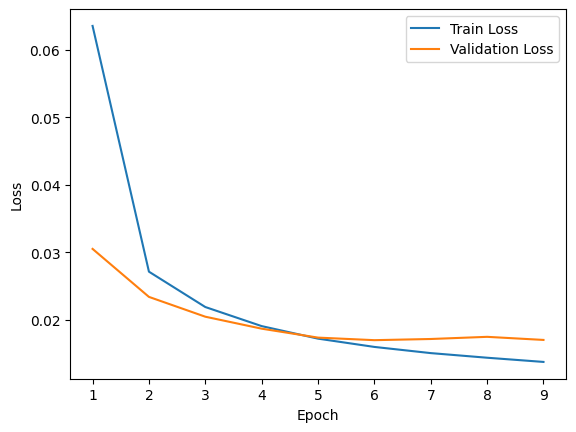

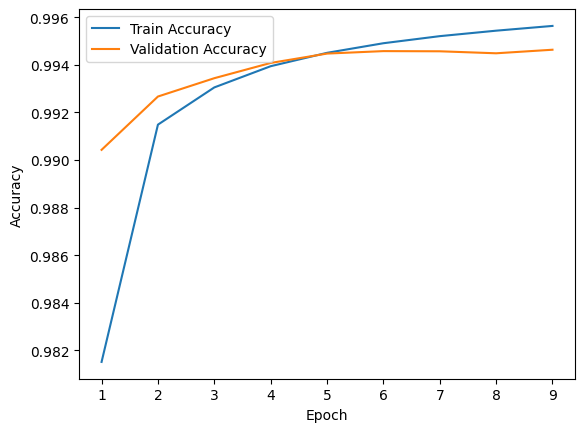

In [44]:
def train_model(model, train_loader, val_loader, epochs, plots):
    train_loss_list = []
    val_loss_list = []
    train_acc_list = []
    val_acc_list = []
    for epoch in range(epochs):
        model.train()
        train_loss = 0.0
        train_correct = 0
        total_train = 0
        for batch_images, batch_labels in train_data_loader:
            batch_images, batch_labels = batch_images.to(device), batch_labels.to(device)

            optimizer.zero_grad()
            outputs = model(batch_images)
            loss = criterion(outputs, batch_labels)
            loss.backward()
            optimizer.step()

            train_loss += loss.item()
            
            train_correct += calculate_accuracy(outputs, batch_labels) * batch_labels.size(0)
            total_train += batch_labels.size(0)

        avg_train_loss = train_loss / len(train_loader)
        train_loss_list.append(avg_train_loss)
        train_accuracy = train_correct / total_train
        train_acc_list.append(train_accuracy)
        # Validation Phase
        model.eval()
        val_loss = 0.0
        val_correct = 0
        total_val = 0

        with torch.no_grad():
            for batch_images, batch_labels in val_loader:
                batch_images, batch_labels = batch_images.to(device), batch_labels.to(device)
                outputs = model(batch_images)
                val_loss += criterion(outputs, batch_labels).item()
                
                val_correct += calculate_accuracy(outputs, batch_labels.view(-1)) * batch_labels.size(0)
                total_val += batch_labels.size(0)

        avg_val_loss = val_loss / len(val_loader)
        val_loss_list.append(avg_val_loss)
        val_accuracy = val_correct / total_val
        val_acc_list.append(val_accuracy)
        
        #scheduler.step(avg_val_loss)

        print(f'Epoch {epoch + 1}: '
                f'Train Loss: {avg_train_loss:.4f}, '
                f'Train Accuracy: {train_accuracy:.4f}, '
                f'Validation Loss: {avg_val_loss:.4f}, '
                f'Validation Accuracy: {val_accuracy:.4f}')

    if plots:
        plt.plot(range(1, epochs + 1), train_loss_list, label='Train Loss')
        plt.plot(range(1, epochs + 1), val_loss_list, label='Validation Loss')
        plt.xlabel('Epoch')
        plt.ylabel('Loss')
        plt.legend()
        plt.show()

        plt.plot(range(1, epochs + 1), train_acc_list, label='Train Accuracy')
        plt.plot(range(1, epochs + 1), val_acc_list, label='Validation Accuracy')
        plt.xlabel('Epoch')
        plt.ylabel('Accuracy')
        plt.legend()
        plt.show()
            
train_model(model, train_data_loader, eval_data_loader, 9, plots = True)


In [45]:
from torch.utils.data import TensorDataset, DataLoader
test_dataset = TensorDataset(test_images_processed)

batch_size = 64 
test_data_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

In [46]:
all_predictions = []

model.eval()

for batch in test_data_loader:
    images = batch[0] 
    images = images.to(device)

    with torch.no_grad():
        outputs = model(images)

    predicted_labels = torch.argmax(outputs, dim=1)
    #print(predicted_labels)
    all_predictions.append(predicted_labels)

all_predictions_tensor = torch.cat(all_predictions, dim=0)


In [47]:
all_predictions_tensor.shape

torch.Size([810000])

In [48]:
all_predictions_np = all_predictions_tensor.cpu().numpy()
reshaped_predictions = np.reshape(all_predictions_np, (10000, 9, 9))
reshaped_predictions[0,:,:]

array([[2, 0, 7, 0, 1, 3, 4, 0, 0],
       [8, 0, 6, 0, 4, 9, 2, 3, 5],
       [9, 0, 3, 0, 0, 6, 8, 0, 0],
       [0, 9, 0, 0, 5, 0, 0, 2, 0],
       [1, 0, 8, 9, 7, 0, 5, 6, 0],
       [0, 3, 0, 0, 0, 2, 0, 0, 8],
       [3, 6, 1, 4, 0, 0, 7, 8, 0],
       [0, 8, 0, 0, 0, 7, 0, 1, 0],
       [4, 0, 2, 0, 8, 0, 3, 0, 0]])

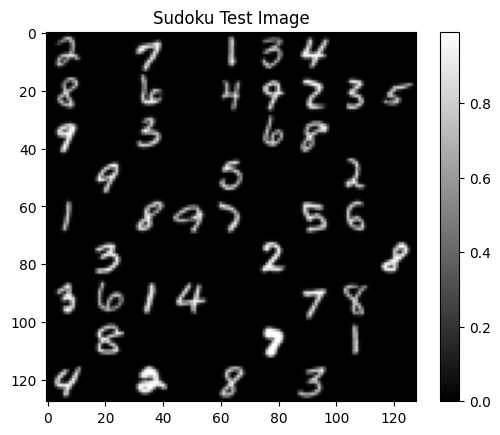

In [49]:
import matplotlib.pyplot as plt

image = normalized_resized_test_images[0, :, :]

plt.imshow(image, cmap='gray')  
plt.title('Sudoku Test Image')
plt.colorbar()  
plt.show()


In [50]:
rows = []

for image in range(reshaped_predictions.shape[0]):
    for x in range(reshaped_predictions.shape[1]):
        for y in range(reshaped_predictions.shape[2]):
            cell_id = f'{image}_{x}{y}'
            cell_value = reshaped_predictions[image][x][y]
            rows.append({'id': cell_id, 'value': cell_value})

In [51]:
import pandas as pd
df = pd.DataFrame(rows)
df['value'] = df['value'].astype(int)

In [52]:
df.to_csv('Submission_Task1_MLP.csv', index=False, header=True)

### Summary
* Normalised and resized given dataset images to handle kernel crashing
* Handled the training labels so as to impute 0 values for missing digits in the sudoku grid
* Flattened each cell of each sudoku grid into a tensor for both images and labels to train MLP moded
* Converted the flattened prediction labels of test images to a 3d tensor (9*9 grids) to easily extract the ids and its values to the submission file

| Task 1     | Model | Dataset | Accuracy(locally) | Accuracy(kaggle) |
|:--------:|:------:|:----------:|:---:|:----------:|
| Approach 1     | CNN  | MNIST   | 99.60% |  99.14 % |
| Approach 2     | MLP  | Task Dataset  | 99.68% | 99.56 %  |